In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import json
import imageio
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.model_selection import StratifiedKFold

%run ../Scripts/Analysis.py
foldername = "test1/"

In [55]:
with open(foldername + "params.json") as json_file:
    params = json.load(json_file)
with open(foldername + "sim_params.json") as json_file:
    sim_params = json.load(json_file)

In [141]:
i = 1
n_i = scipy.sparse.load_npz(foldername+f"sp_frame_n{i}.npz").todok()

In [100]:
indexes = get_nonzero_w_repeats(n_i)
means, covs, counts = fit_unknown_GMM(indexes, n_components = 10, w = 10000)
len(counts)

10

In [66]:
def sum_GMM(mean1, mean2, cov1, cov2, count1, count2):
    res_mean = (mean1+mean2)/2
    res_cov = (cov1+cov2)/2
    res_count = count1 + count2
    return res_mean, res_cov, res_count

def check_if_inside_GMM(mean1, mean2, covs1):
    diff = mean1-mean2
    x_diff = diff[0]**2
    y_diff = diff[1]**2

    if isinstance(covs1,float):
        covs1 = np.eye(means.size)*covs1

    eigval, _ = np.linalg.eigh(covs1)
    
    res = x_diff/(eigval[0]**2) + y_diff/(eigval[1]**2)
    return res

In [ ]:
means_res = [means[0]]
covs_res = [covs[0]]
count_res = [counts[0]]
i = 0

for mean , cov, count in zip(means, covs, counts):
    mean_curr = means[i]
    cov_curr = covs[i]
    diff = mean-mean_curr

    if check_if_inside_GMM(mean, mean_curr, cov_curr) < 1:
        new_mean, new_cov = sum_GMM(mean, mean_curr, covs1, covs2)
        continue

    if check_if_inside_GMM(mean, mean_curr, cov) < 1:
        new_mean, new_cov = sum_GMM(mean, mean_curr, covs1, covs2)
        continue

    means_spred.append(mean)
    covs_spred.append(cov)
    i += 1

In [105]:
def Multivar_Normal(x, mean, cov, count):
    diff = x-mean
    Mahalanobis = np.matmul(diff.transpose(), np.matmul(cov, diff))
    pdf = np.exp((-1/2)*Mahalanobis)
    norm = np.sqrt(np.power(2*np.pi, 2)*np.linalg.det(cov))
    pdf = pdf/norm
    return pdf*count

def Sum_Normal(n, means, covs, counts):
    sum_Normal = scipy.sparse.dok_matrix(n.shape)
    x_inds, y_inds = n_i.nonzero()

    for mean, cov, count in zip(means, covs, counts):
        for x_ind, y_ind in zip(x_inds, y_inds):
            sum_Normal[x_ind, y_ind] += Multivar_Normal([x_ind, y_ind], 
                                                    mean, cov, count)
        return sum_Normal
    
    return sum_Normal
    
    


In [115]:
gaussian_estimator.predict(np.array([x_inds, y_inds]).transpose())

(270,)

In [131]:
n_components = 1
index_nonzero_w_repeats = get_nonzero_w_repeats(n_i)
cov_type = "full"

gaussian_estimator =  GaussianMixture(
            n_components= n_components,
            init_params="kmeans",
            max_iter=1500,
            covariance_type= cov_type,
        )
gaussian_estimator.fit(index_nonzero_w_repeats)

covs = gaussian_estimator.covariances_
means = gaussian_estimator.means_
clusters = gaussian_estimator.predict(index_nonzero_w_repeats)
_ , counts = np.unique(clusters, return_counts= True)

calc_data = Sum_Normal(n_i, means, covs, counts)
x_inds, y_inds = n_i.nonzero()
classification = gaussian_estimator.predict(np.array([x_inds, y_inds]).transpose())

chi_sqr = 0
for x_ind, y_ind, i in zip(x_inds, y_inds, classification):
    diff = n_i[x_ind, y_ind] - calc_data[x_ind, y_ind]
    variance = np.linalg.det(covs[i])

    chi_sqr += np.power(diff, 2)/variance

deg_freedom = n_components*5

chi_sqr/deg_freedom

1295448.4369299945

In [140]:
np.sum(n_i)

100000

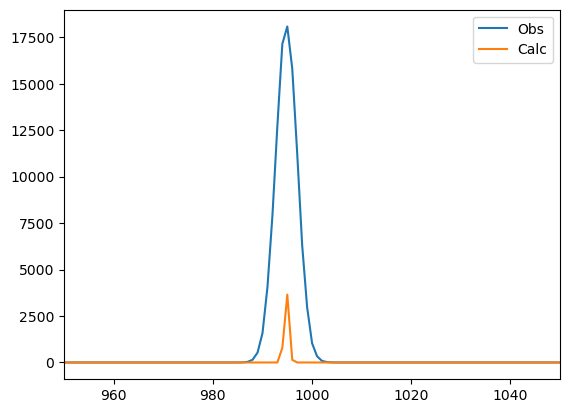

In [135]:
plt.plot(np.sum(n_i.toarray(), axis =0), label = "Obs")
plt.plot(np.sum(calc_data.toarray(), axis =0), label = "Calc")
plt.xlim(950, 1050)
plt.legend()

In [122]:
diff.transpose()

1.0

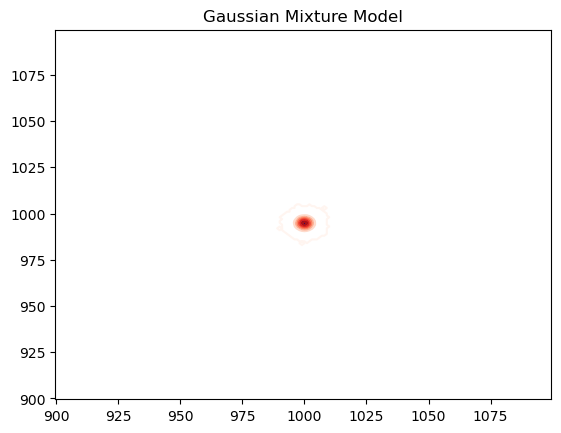

In [73]:
fig, ax = plt.subplots()
plt.title("Gaussian Mixture Model")
ax.contour(n_i.toarray().transpose(), cmap = "Reds") #Note that contour is trasnposed
ax.margins(-0.45, -0.45)
for mean , cov in zip(means, covs):
    ell1 = make_ellipse(mean, cov, "navy")
    ax.add_patch(ell1)

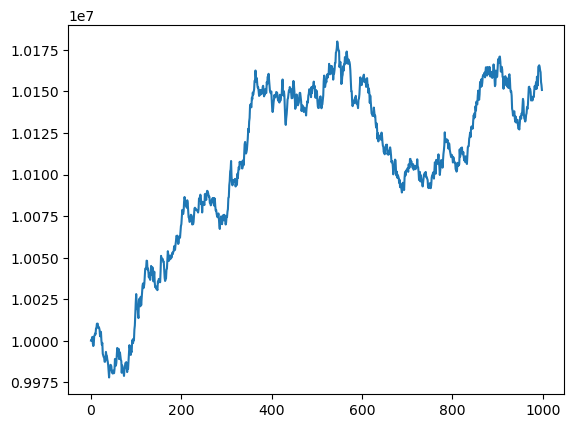

In [145]:
temp = np.zeros(999)
foldername = "test2/"
for i in range(999):
    n_i = scipy.sparse.load_npz(foldername+f"sp_frame_n{i}.npz").todok()
    temp[i] = np.sum(n_i)

plt.plot(temp)